In [1]:
# Configure the matplotlib graphics library and configure it to show 
# figures inline in the notebook

#%matplotlib widget                        
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np               # Import Numerical Python
import scipy as sp
import random
import h5py
import PIL
import copy
from scipy.optimize import curve_fit
import scipy.io
from IPython.core.display import display, HTML #Import HTML for formatting output

import arc
from arc import *                 #Import ARC (Alkali Rydberg Calculator)
from qutip import *
plt.rcParams['figure.figsize'] = [10, 5]

<ipython-input-1-ce88f8db4ce3>:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML #Import HTML for formatting output


In [295]:
#User-specified params are all in this cell
atom = Caesium()
omega = 3e6 #Rabi frequency in Hz
delta = 0 #Two-photon detuning in Hz
gamma = 1/2e-6
gammaextra = 1/1e-6
#Rydberg state quantum numbers
n = 55
l = 0
j = 0.5
r = 3.5 #lattice spacing in um

#First specify an array pattern with rows and columns of 0s and 1s.
subspace = np.array([[1,0,1,0,0],[0,0,0,0,0]])


In [301]:
-0.5*pol66*(.3**2)

-16.785

In [321]:
#Params for E field fluctuation
pol66 = 373 #MHz*(v/cm)^-2, from literature, for Cs 66 state
pol48 = 42
efield_var = .3 #variance of E field in V/cm

#Random E field choice
#Also incorporates fluctuating Rabi frequency
#Incorporate from experiment to experiment
def get_fluctuating_field(center_rabi):
    start = -efield_var/2
    end = efield_var/2
    field = np.random.uniform(start,end)
    det_shift = -0.5*pol66*(field**2)
    rabi_shift = np.random.uniform(-.2,.2)
    detuning = det_shift
    rabi = center_rabi+rabi_shift*1e6
    return [rabi, detuning]

def get_fluctuating_field_lowerpol(center_rabi):
    start = -efield_var/2
    end = efield_var/2
    field = np.random.uniform(start,end)
    det_shift = -0.5*pol48*(field**2)
    rabi_shift = np.random.uniform(-.2,.2)
    detuning = det_shift
    rabi = center_rabi+rabi_shift*1e6
    return [rabi, detuning]

#Random intensity
#Incorporate shot-to-shot
#Assume 100's of kHz scale for now
def get_fluctuating_intensity(center_detuning):
    shift = np.random.uniform(-.1,.1)
    return center_detuning-shift


In [322]:
#Single-atom Hamiltonian
def get_hamiltonian(rabi, detuning):
    ham = np.array([[0, rabi/2],[rabi/2,detuning]])
    return Qobj(ham)

#Qutip detection operator for ground state
gsdetect=Qobj(np.array([[1,0],[0,0]]))
#Qutip noise operator
noise=Qobj(np.array([[0,1],[0,0]]))

#ground state
num_atoms = 1
psi0 = fock(2**num_atoms,0)

In [323]:
#Now incorporating shot-to-shot kHz scale fluctuations
#def h0(center_rabi, det):
#    h0 = np.array([[0,center_rabi/2],[center_rabi/2,det]])
#    return Qobj(h1)

#h1 = Qobj(np.array([[0,1/2],[1/2,0]]))
#def h1_coeff(t, args):
#    fluc = np.random.normal(0,100)
    #fluc=0
#    return 1e3*fluc



times = np.linspace(0.0, 6e-6, 2000)
psit_arr = []
psit_arr_48 = []
num_expts = 50
for i in range(0,num_expts):
    center_rabi = omega
    rabi, detuning = get_fluctuating_field(center_rabi)
    rabi48, detuning48 = get_fluctuating_field_lowerpol(center_rabi)
    #print('detuning is ', detuning)
    #print('rabi is ', rabi)
    psit=mesolve(get_hamiltonian(rabi,detuning*1e6),psi0,times,[np.sqrt(gamma)*noise],gsdetect)
    psit_48=mesolve(get_hamiltonian(center_rabi,detuning48*1e6),psi0,times,[np.sqrt(gamma)*noise],gsdetect)
    gg = psit.expect[0]/num_expts
    gg_48 = psit_48.expect[0]/num_expts
    psit_arr.append(gg)
    psit_arr_48.append(gg_48)

psit_normal = mesolve(get_hamiltonian(omega,0),psi0,times,[np.sqrt(gamma)*noise],gsdetect)
#psit = mesolve(hamiltonian,psi0,times,[np.sqrt(gamma)*noiseop],[gsdetect1])

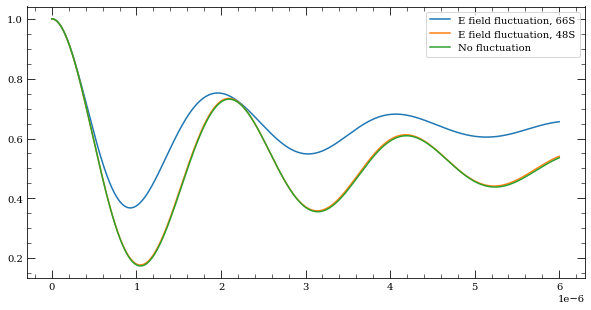

In [324]:
#plt.plot(times,np.sum(psit_arr,axis=0), label='E field and intensity fluctuation')
plt.plot(times,np.sum(psit_arr,axis=0), label='E field fluctuation, 66S')
plt.plot(times,np.sum(psit_arr_48,axis=0), label='E field fluctuation, 48S')
plt.plot(times,psit_normal.expect[0], label='No fluctuation')
plt.legend()
plt.show()

In [208]:
#Only experiment-to-experiment E field noise
times = np.linspace(0.0, 6e-6, 2000)
psit_arr_eonly = []
num_expts = 50
for i in range(0,num_expts):
    center_rabi = 3.88e6
    rabi, detuning = get_fluctuating_field(center_rabi)
    psit=mesolve(get_hamiltonian(center_rabi,detuning*1e6),psi0,times,[np.sqrt(gamma)*noise],gsdetect)
    gg = psit.expect[0]/num_expts
    psit_arr_eonly.append(gg)


#psit_normal = mesolve(get_hamiltonian(3.88e6,0),psi0,times,[np.sqrt(gamma)*noise],gsdetect)
#psit = mesolve(hamiltonian,psi0,times,[np.sqrt(gamma)*noiseop],[gsdetect1])

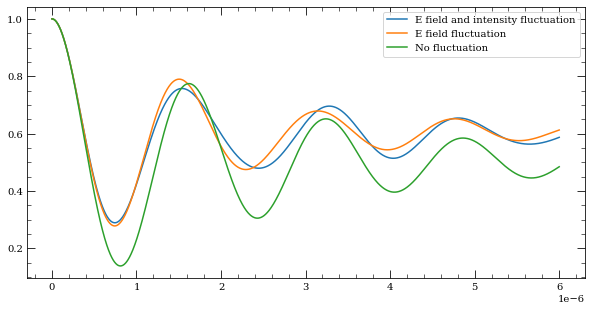

In [209]:
plt.plot(times,np.sum(psit_arr,axis=0), label='E field and intensity fluctuation')
plt.plot(times,np.sum(psit_arr_eonly,axis=0), label='E field fluctuation')
plt.plot(times,psit_normal.expect[0], label='No fluctuation')
plt.legend()
plt.show()

# Effect of mixing on 66S

In [365]:
#First compute polarizabilities for 48S, 55S, 66S
#Use interactive Stark maps
#Stark Map Caclulator
#====================
#Initialise a Stark-shift Solver for Caesium
ncalc = [48, 55, 66]
basisrange = 5
for n in ncalc:
    calc = StarkMap(Caesium())
    #Target state
    print('Calculating Stark map for n=%i' % n)
    n0=n;l0=0;j0=0.5;mj0=0.5;
    #Define max/min n values in basis
    nmax=n+basisrange
    nmin=n-basisrange
    #Maximum value of l to include (l~20 gives good convergence for states with l<5)
    lmax=20

    #Initialise Basis States for Solver : progressOutput=True gives verbose output
    calc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)

    Emin=0. #Min E field (V/m)
    Emax=10000. #Max E field (V/m)
    N=501 #Number of Points
    #Generate Stark Map
    calc.diagonalise(np.linspace(Emin,Emax,N), progressOutput=True)
    #Show Sark Map
    calc.plotLevelDiagram(progressOutput=True,units=1,highlightState = True)
    calc.showPlot(interactive = True)
    #Return Polarizability of target state
    print("%.5f MHz cm^2 / V^2 " % calc.getPolarizability(showPlot=True, minStateContribution=0.9))


OperationalError: database is locked

Found  0  states.
Generating matrix...


Finding eigenvectors...
100%

plotting...


IndexError: list index out of range

Calculating Stark map for n=60
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


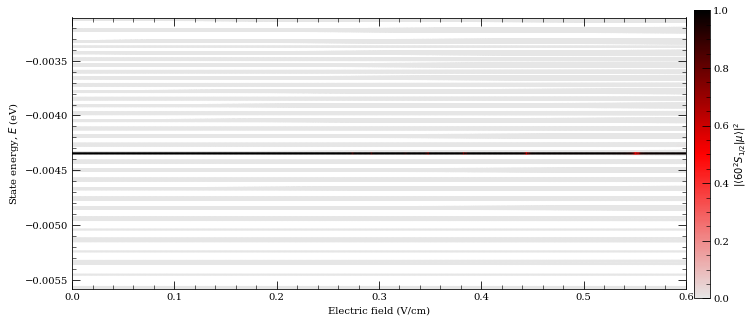

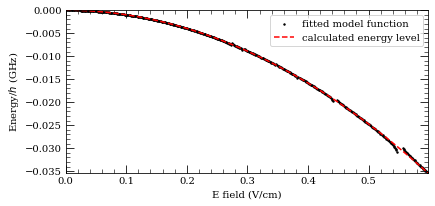

197.93003 MHz cm^2 / V^2 


In [7]:
#Comparison of Cs and Rb at 66S in terms of Stark map
#First Cs
calc = StarkMap(Caesium())
n=60
#Target state
print('Calculating Stark map for n=%i' % n)
n0=n;l0=0;j0=0.5;mj0=0.5;
#Define max/min n values in basis
nmax=n+7
nmin=n-7
#Maximum value of l to include (l~20 gives good convergence for states with l<5)
lmax=20

#Initialise Basis States for Solver : progressOutput=True gives verbose output
calc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)

Emin=0. #Min E field (V/m)
Emax=60. #Max E field (V/m)
N=501 #Number of Points
#Generate Stark Map
calc.diagonalise(np.linspace(Emin,Emax,N), progressOutput=True)
#Show Sark Map
calc.plotLevelDiagram(progressOutput=True,units=1,highlightState = True)
calc.showPlot(interactive=False)
#Return Polarizability of target state
print("%.5f MHz cm^2 / V^2 " % calc.getPolarizability(showPlot=True, minStateContribution=0.9))

Calculating Stark map for n=55
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


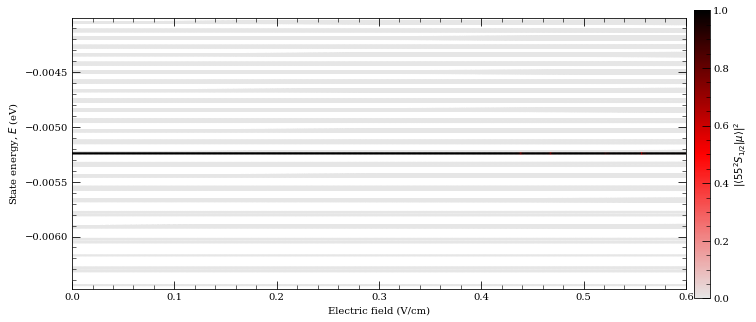

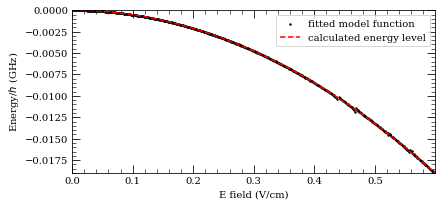

105.98175 MHz cm^2 / V^2 
Calculating Stark map for n=56
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


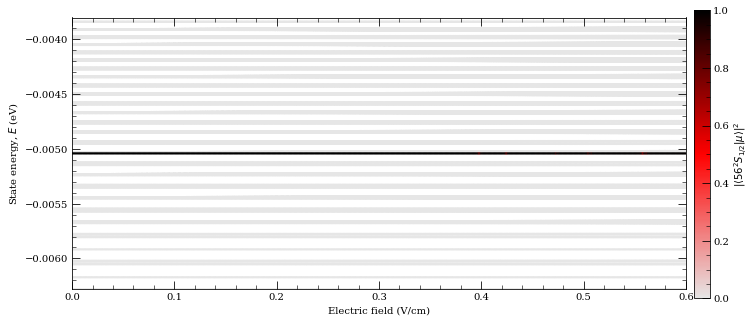

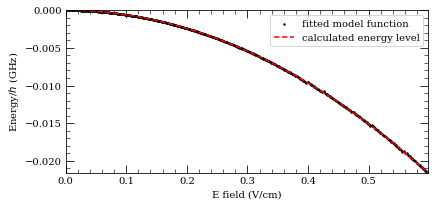

120.59809 MHz cm^2 / V^2 
Calculating Stark map for n=57
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


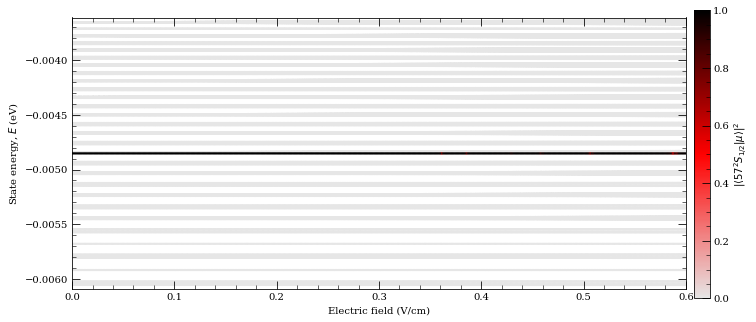

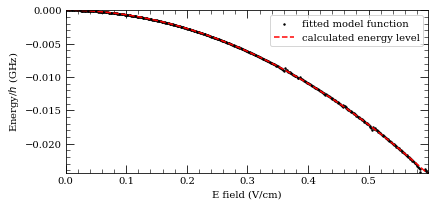

137.14830 MHz cm^2 / V^2 
Calculating Stark map for n=58
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


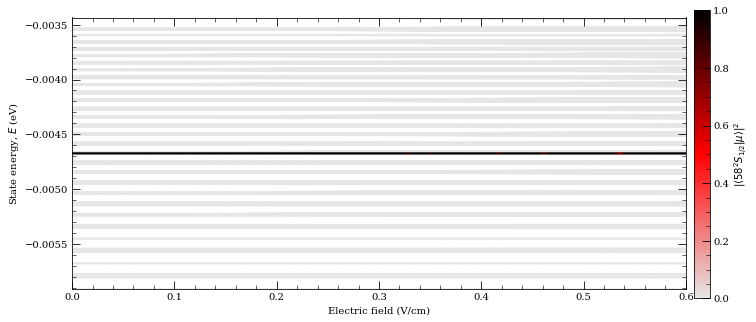

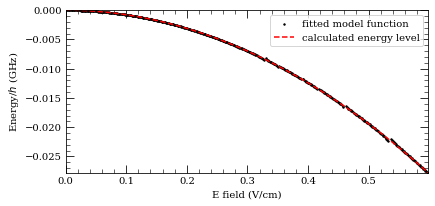

155.20659 MHz cm^2 / V^2 
Calculating Stark map for n=59
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


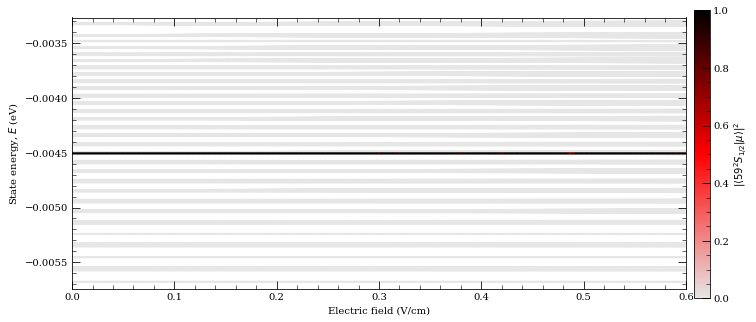

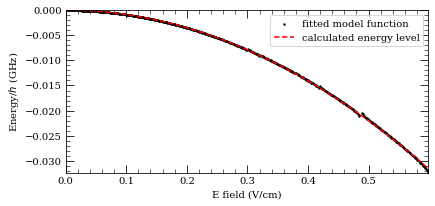

176.25334 MHz cm^2 / V^2 
Calculating Stark map for n=60
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


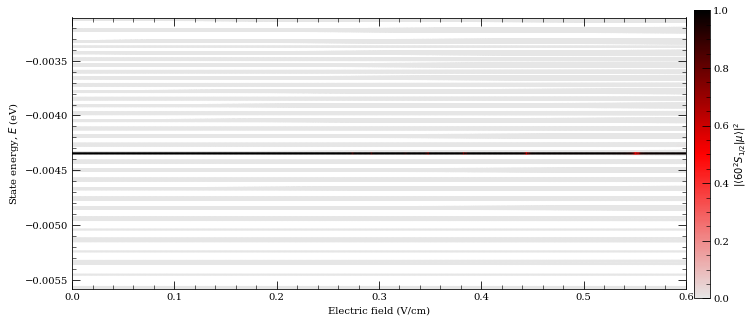

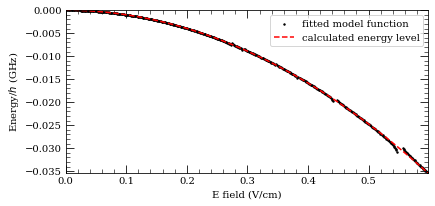

197.93003 MHz cm^2 / V^2 
Calculating Stark map for n=61
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


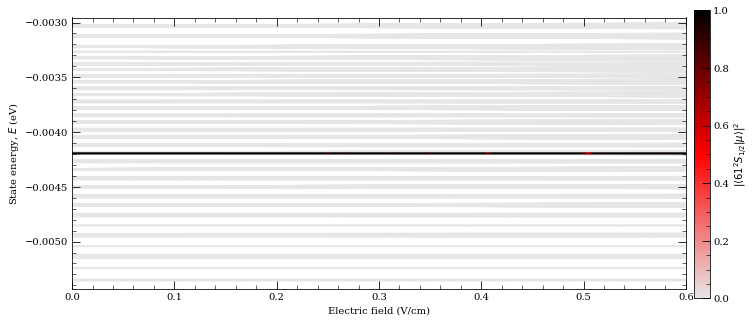

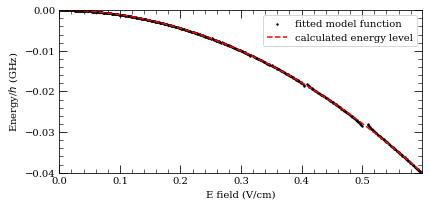

223.02099 MHz cm^2 / V^2 
Calculating Stark map for n=62
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


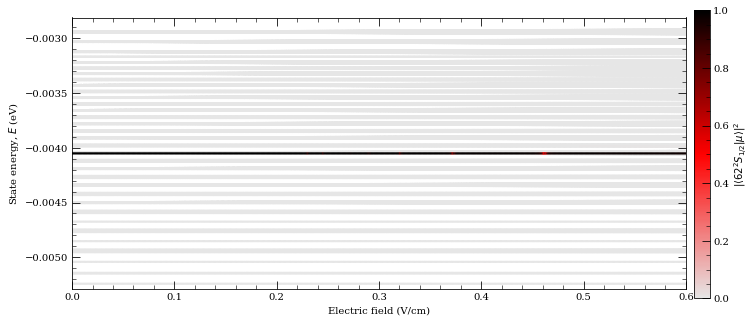

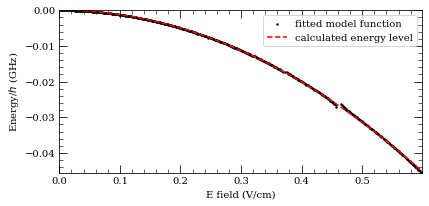

251.77665 MHz cm^2 / V^2 
Calculating Stark map for n=63
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


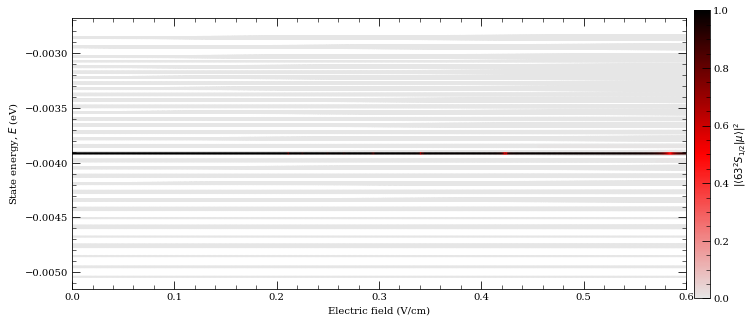

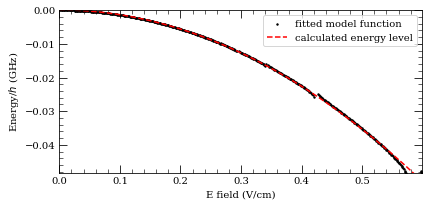

283.51473 MHz cm^2 / V^2 
Calculating Stark map for n=64
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


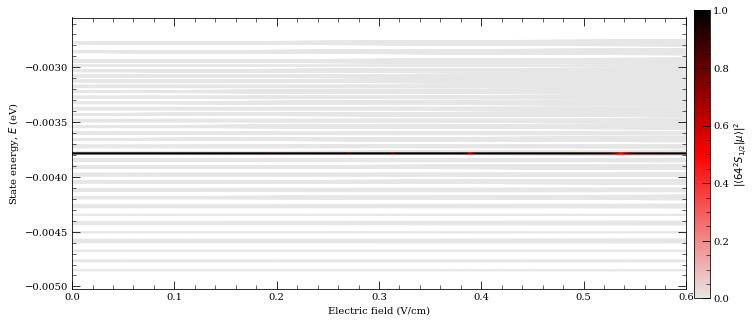

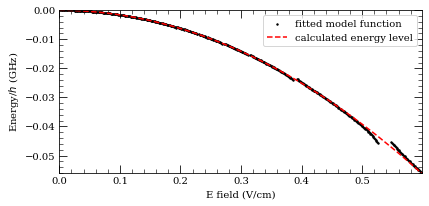

313.49708 MHz cm^2 / V^2 
Calculating Stark map for n=65
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


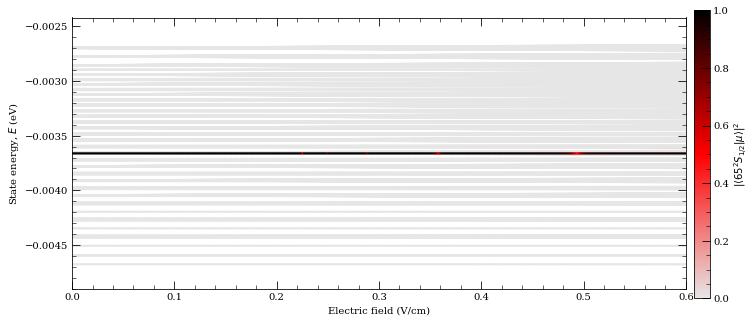

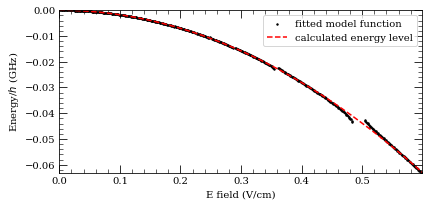

350.77178 MHz cm^2 / V^2 
Calculating Stark map for n=66
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


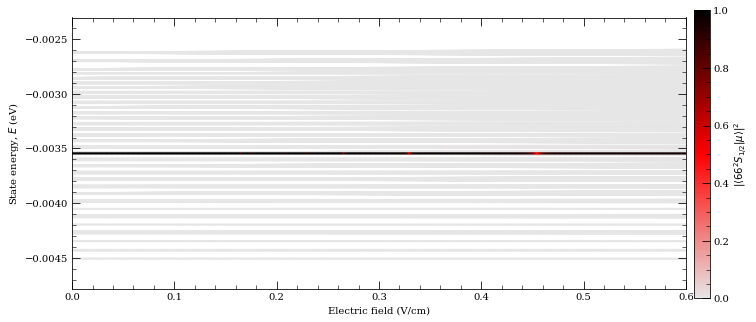

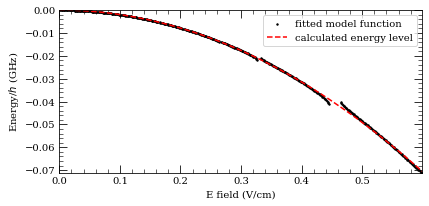

393.52748 MHz cm^2 / V^2 
Calculating Stark map for n=67
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


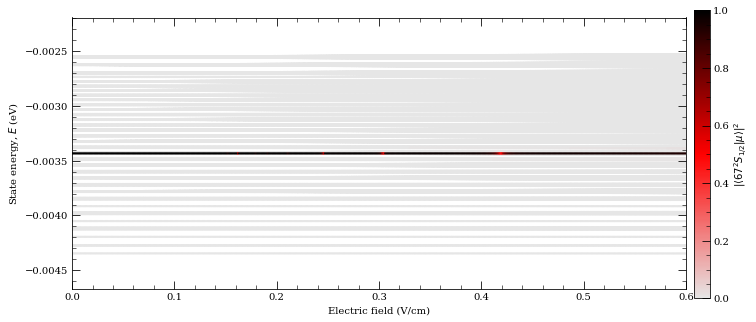

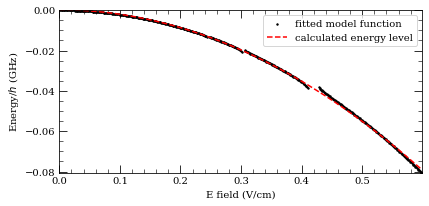

442.61542 MHz cm^2 / V^2 
Calculating Stark map for n=68
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


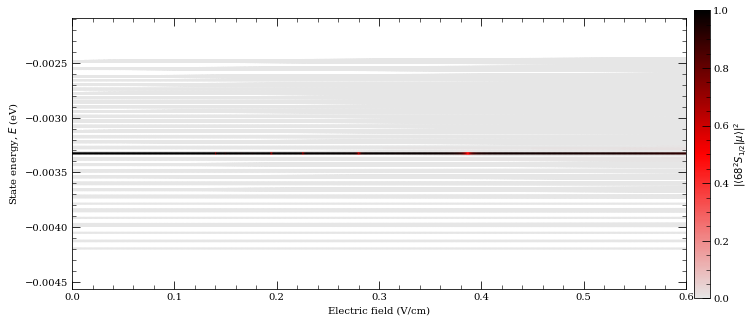

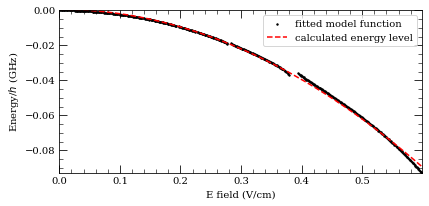

500.98353 MHz cm^2 / V^2 
Calculating Stark map for n=69
Found  574  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


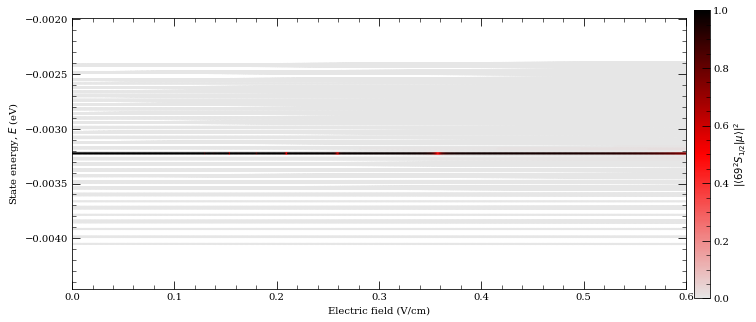

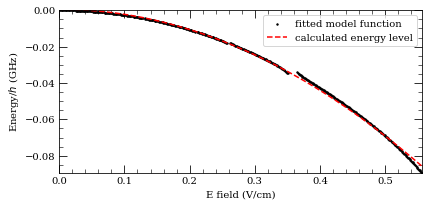

556.85653 MHz cm^2 / V^2 


In [17]:
nmin = 55
nmax = 70
for n in range(nmin,nmax):
    #Comparison of Cs and Rb at 66S in terms of Stark map
    #First Cs
    calc = StarkMap(Caesium())
    #Target state
    print('Calculating Stark map for n=%i' % n)
    n0=n;l0=0;j0=0.5;mj0=0.5;
    #Define max/min n values in basis
    nmax=n+7
    nmin=n-7
    #Maximum value of l to include (l~20 gives good convergence for states with l<5)
    lmax=20

    #Initialise Basis States for Solver : progressOutput=True gives verbose output
    calc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)

    Emin=0. #Min E field (V/m)
    Emax=60. #Max E field (V/m)
    N=501 #Number of Points
    #Generate Stark Map
    calc.diagonalise(np.linspace(Emin,Emax,N), progressOutput=True)
    #Show Sark Map
    calc.plotLevelDiagram(progressOutput=True,units=1,highlightState = True)
    calc.showPlot(interactive=False)
    #Return Polarizability of target state
    print("%.5f MHz cm^2 / V^2 " % calc.getPolarizability(showPlot=True, minStateContribution=0.9))

In [ ]:


#Comparison of Cs and Rb at 66S in terms of Stark map
#First Cs
calc = StarkMap(Caesium())
n=60
#Target state
print('Calculating Stark map for n=%i' % n)
n0=n;l0=2;j0=1.5;mj0=1.5;
#Define max/min n values in basis
nmax=n+7
nmin=n-7
#Maximum value of l to include (l~20 gives good convergence for states with l<5)
lmax=20

#Initialise Basis States for Solver : progressOutput=True gives verbose output
calc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)

Emin=0. #Min E field (V/m)
Emax=60. #Max E field (V/m)
N=501 #Number of Points
#Generate Stark Map
calc.diagonalise(np.linspace(Emin,Emax,N), progressOutput=True)
#Show Sark Map
calc.plotLevelDiagram(progressOutput=True,units=1,highlightState = True)
calc.showPlot(interactive=False)
#Return Polarizability of target state
print("%.5f MHz cm^2 / V^2 " % calc.getPolarizability(showPlot=True, minStateContribution=0.9))

Calculating Stark map for n=60
Found  546  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


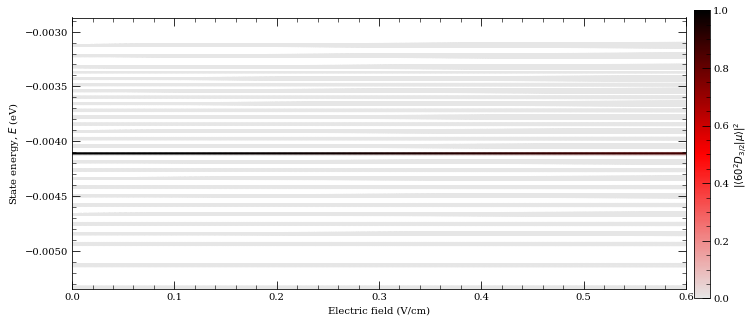

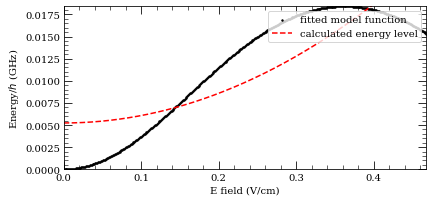

-167.54002 MHz cm^2 / V^2 


In [11]:
#Comparison of Cs and Rb at 66S in terms of Stark map
#First Cs
calc = StarkMap(Caesium())
n=60
#Target state
print('Calculating Stark map for n=%i' % n)
n0=n;l0=2;j0=1.5;mj0=1.5;
#Define max/min n values in basis
nmax=n+7
nmin=n-7
#Maximum value of l to include (l~20 gives good convergence for states with l<5)
lmax=20

#Initialise Basis States for Solver : progressOutput=True gives verbose output
calc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)

Emin=0. #Min E field (V/m)
Emax=60. #Max E field (V/m)
N=501 #Number of Points
#Generate Stark Map
calc.diagonalise(np.linspace(Emin,Emax,N), progressOutput=True)
#Show Sark Map
calc.plotLevelDiagram(progressOutput=True,units=1,highlightState = True)
calc.showPlot(interactive=False)
#Return Polarizability of target state
print("%.5f MHz cm^2 / V^2 " % calc.getPolarizability(showPlot=True, minStateContribution=0.9))

In [344]:
calc.y[0]

array([-1014.32491192,  -998.21445694,  -997.081022  ,  -979.62031003,
        -964.32636615,  -963.25013056,  -960.49964467,  -960.19971458,
        -946.66681371,  -932.1351237 ,  -931.11230265,  -928.49833526,
        -928.21326652,  -915.34856552,  -901.52930502,  -900.55642163,
        -898.07008372,  -897.79891051,  -885.55913371,  -885.09264684,
        -885.09264684,  -884.32848555,  -884.19166159,  -884.19166159,
        -884.15166917,  -884.15166917,  -884.13723117,  -884.13723117,
        -884.13117595,  -884.13117595,  -884.12833812,  -884.12833812,
        -884.12688916,  -884.12688916,  -884.12609715,  -884.12609715,
        -884.1256395 ,  -884.1256395 ,  -884.12536256,  -884.12536256,
        -884.12518832,  -884.12518832,  -884.12507498,  -884.12507498,
        -884.1249991 ,  -884.1249991 ,  -884.124947  ,  -884.124947  ,
        -884.12491042,  -884.12491042,  -884.12488423,  -884.12488423,
        -884.12486514,  -884.12486514,  -884.12479985,  -872.40648366,
      

[55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]


testing field 15.000
testing field 15.816
testing field 16.633
testing field 17.449
testing field 18.265
testing field 19.082
testing field 19.898
testing field 20.714
testing field 21.531
testing field 22.347
testing field 23.163
testing field 23.980
testing field 24.796
testing field 25.612
testing field 26.429
testing field 27.245
testing field 28.061
testing field 28.878
testing field 29.694
testing field 30.510
testing field 31.327
testing field 32.143
testing field 32.959
testing field 33.776
testing field 34.592
testing field 35.408
testing field 36.224
testing field 37.041
testing field 37.857
testing field 38.673
testing field 39.490
testing field 40.306
testing field 41.122
testing field 41.939
testing field 42.755
testing field 43.571
testing field 44.388
testing field 45.204
testing field 46.020
testing field 46.837
testing field 47.653
testing field 48.469
testing field 49.286
testing field 50.102
testing field 50.918
testing field 51.735
testing field 52.551
testing field

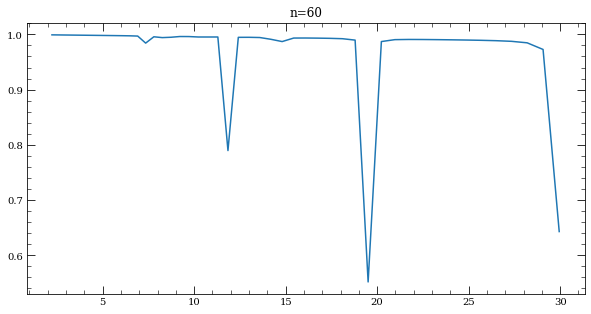

In [18]:
#n=60
percentagearray = []
shifts = []
fields = np.linspace(15,55,50)#in V/m
for efield in fields:
    print('testing field %.3f' % efield)
    shift = (1/2)*198*((efield/100)**2)
    #calculate resulting shift to blue 
    shifts.append(shift)
    percentagearray.append(calc.getState([60,0,0.5,0.5], efield, 53, 67, 20)[1][0]**2)
plt.title('n=60')
plt.plot(shifts, percentagearray)

testing field 0.000
testing field 0.741
testing field 1.481
testing field 2.222
testing field 2.963
testing field 3.704
testing field 4.444
testing field 5.185
testing field 5.926
testing field 6.667
testing field 7.407
testing field 8.148
testing field 8.889
testing field 9.630
testing field 10.370
testing field 11.111
testing field 11.852
testing field 12.593
testing field 13.333
testing field 14.074
testing field 14.815
testing field 15.556
testing field 16.296
testing field 17.037
testing field 17.778
testing field 18.519
testing field 19.259
testing field 20.000
testing field 20.741
testing field 21.481
testing field 22.222
testing field 22.963
testing field 23.704
testing field 24.444
testing field 25.185
testing field 25.926
testing field 26.667
testing field 27.407
testing field 28.148
testing field 28.889
testing field 29.630
testing field 30.370
testing field 31.111
testing field 31.852
testing field 32.593
testing field 33.333
testing field 34.074
testing field 34.815
testin

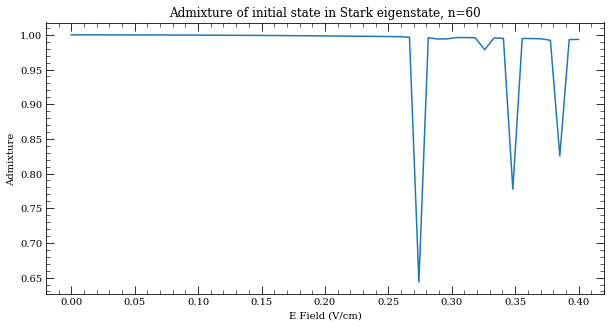

In [3]:
#n=60
calc = StarkMap(Caesium())
percentagearray = []
shifts = []
fields = np.linspace(0,40,55)#in V/m
for efield in fields:
    print('testing field %.3f' % efield)
    #shift = (1/2)*197.93003*((efield/100)**2)
    #calculate resulting shift to blue 
    shifts.append(efield/100)
    percentagearray.append(calc.getState([60,0,0.5,0.5], efield, 53, 67, 20)[1][0]**2)
plt.title('Admixture of initial state in Stark eigenstate, n=60')
plt.xlabel('E Field (V/cm)')
plt.ylabel('Admixture')
plt.plot(shifts, percentagearray)

testing field 0.000
testing field 0.134
testing field 0.268
testing field 0.401
testing field 0.535
testing field 0.669
testing field 0.803
testing field 0.936
testing field 1.070
testing field 1.204
testing field 1.338
testing field 1.472
testing field 1.605
testing field 1.739
testing field 1.873
testing field 2.007
testing field 2.140
testing field 2.274
testing field 2.408
testing field 2.542
testing field 2.676
testing field 2.809
testing field 2.943
testing field 3.077
testing field 3.211
testing field 3.344
testing field 3.478
testing field 3.612
testing field 3.746
testing field 3.880
testing field 4.013
testing field 4.147
testing field 4.281
testing field 4.415
testing field 4.548
testing field 4.682
testing field 4.816
testing field 4.950
testing field 5.084
testing field 5.217
testing field 5.351
testing field 5.485
testing field 5.619
testing field 5.753
testing field 5.886
testing field 6.020
testing field 6.154
testing field 6.288
testing field 6.421
testing field 6.555


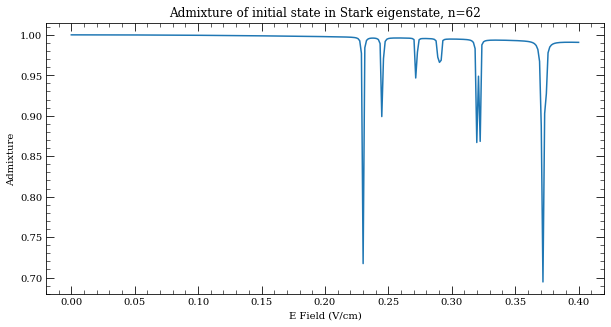

In [14]:
#n=55
calc = StarkMap(Caesium())
percentagearray = []
shifts = []
fields = np.linspace(0,40,300)#in V/m
for efield in fields:
    print('testing field %.3f' % efield)
    #shift = (1/2)*197.93003*((efield/100)**2)
    #calculate resulting shift to blue 
    shifts.append(efield/100)
    percentagearray.append(calc.getState([62,0,0.5,0.5], efield, 52, 72, 20)[1][0]**2)
plt.title('Admixture of initial state in Stark eigenstate, n=62')
plt.xlabel('E Field (V/cm)')
plt.ylabel('Admixture')
plt.plot(shifts, percentagearray)

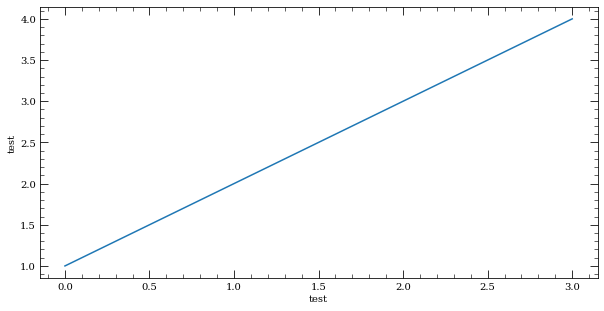

In [8]:
test = [1,2,3,4]
plt.xlabel('test')
plt.ylabel('test')
plt.plot(test)

In [6]:
percentagearray = []
shifts = []
fields = np.linspace(15,55,50)#in V/m
for efield in fields:
    print('testing field %.3f' % efield)
    shift = (1/2)*373*((efield/100)**2)
    #calculate resulting shift to blue 
    shifts.append(efield)
    percentagearray.append(calc.getState([66,0,0.5,0.5], efield, 55, 75, 20)[1][0]**2)
plt.plot(shifts, percentagearray)

testing field 15.000


OperationalError: database is locked

In [359]:
np.linspace(35,45,20)

array([35.        , 35.52631579, 36.05263158, 36.57894737, 37.10526316,
       37.63157895, 38.15789474, 38.68421053, 39.21052632, 39.73684211,
       40.26315789, 40.78947368, 41.31578947, 41.84210526, 42.36842105,
       42.89473684, 43.42105263, 43.94736842, 44.47368421, 45.        ])